# **Hands On Graph Neural Networks Using Python  -  CHAPTER 9**


- This code is a comprehensive pipeline for graph classification using graph neural networks (GNNs). It starts by loading and preprocessing the PROTEINS dataset from the TUDataset collection, splitting it into training, validation, and test sets, and creating data loaders.

- Two GNN models, `Graph Convolutional Network (GCN)` and Graph Isomorphism Network (GIN), are implemented and trained separately. Each model includes multiple graph convolution layers followed by global pooling and classification layers.

- The `Trainer` class is responsible for training these models and evaluating their performance, calculating loss and accuracy metrics. The `Visualization` class plots the classification results for both models, highlighting correct and incorrect predictions on sample graphs.

- Finally, the `EnsembleEvaluator` class assesses the performance of an ensemble model that combines the predictions of GCN and GIN, providing a comparative accuracy evaluation. This pipeline offers a complete workflow for training, evaluating, and visualizing GNN models on graph classification tasks.

In [2]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [12]:
import torch
import numpy as np
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool, global_add_pool


### **Set up reproducibility**


In [13]:
torch.manual_seed(11)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **GraphDataset Class**

- This class manages the loading, preprocessing, and splitting of the dataset. It is responsible for initializing the dataset, providing information about its structure, and creating data loaders for `training`, `validation`, and `testing`.

  - **Initialization:** Loads the dataset specified by dataset_name and root, shuffles it, and stores the number of features and classes.

In [14]:
class GraphDataset:
    """Handles the loading and preprocessing of the dataset."""
    def __init__(self, dataset_name='PROTEINS', root='.'):
        self.dataset = TUDataset(root=root, name=dataset_name).shuffle()
        self.num_classes = self.dataset.num_classes
        self.num_features = self.dataset.num_features

    def print_dataset_info(self):
        print(f'Dataset: {self.dataset}')
        print('-----------------------')
        print(f'Number of graphs: {len(self.dataset)}')
        print(f'Number of nodes: {self.dataset[0].x.shape[0]}')
        print(f'Number of features: {self.num_features}')
        print(f'Number of classes: {self.num_classes}')

    def split_dataset(self):
        total_size = len(self.dataset)
        train_size = int(total_size * 0.8)
        val_size = int(total_size * 0.1)
        test_size = total_size - train_size - val_size
        self.train_dataset = self.dataset[:train_size]
        self.val_dataset = self.dataset[train_size:train_size + val_size]
        self.test_dataset = self.dataset[train_size + val_size:]
        print(f'Training set   = {len(self.train_dataset)} graphs')
        print(f'Validation set = {len(self.val_dataset)} graphs')
        print(f'Test set       = {len(self.test_dataset)} graphs')

    def create_loaders(self, batch_size=64):
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=True)

### **Graph Convolutional Network (GCN) model Class**

- This class defines a `Graph Convolutional Network (GCN) model`. The model consists of multiple graph convolution layers followed by a linear layer for classification.

  - **Initialization:** Initializes three `graph convolution layers (GCNConv)` and a linear layer. The input dimensions are based on the dataset features and the output dimensions are based on the number of classes.

  - **forward(x, edge_index, batch):** Defines the forward pass of the model, which includes applying the graph convolution layers, a global pooling operation, and a classifier with dropout. It returns the `log-softmax` of the predicted class probabilities.


In [15]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network (GCN) model."""
    def __init__(self, dim_h, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, num_classes)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index)
        hG = global_mean_pool(h, batch)
        h = F.dropout(hG, p=0.5, training=self.training)
        return F.log_softmax(self.lin(h), dim=1)

### **Graph Isomorphism Network (GIN) model Class**

- This class defines a `Graph Isomorphism Network (GIN) model`. The model features multiple graph convolution layers with learnable `multi-layer perceptrons (MLPs)` and a classifier that concatenates the embeddings from different layers.

  - **Initialization:** Initializes three `GINConv layers` with MLPs and Batch Normalization, followed by two linear layers for classification. The input and output dimensions are based on the dataset.

  - **forward(x, edge_index, batch)**: Defines the forward pass of the model, which includes applying the `GIN layers`, global pooling operations, concatenating the embeddings, and a classifier with dropout. It returns the log-softmax of the predicted class probabilities.

In [16]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network (GIN) model."""
    def __init__(self, dim_h, num_features, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(Linear(num_features, dim_h),
                                        BatchNorm1d(dim_h),
                                        ReLU(),
                                        Linear(dim_h, dim_h),
                                        ReLU()))
        self.conv2 = GINConv(Sequential(Linear(dim_h, dim_h),
                                        BatchNorm1d(dim_h),
                                        ReLU(),
                                        Linear(dim_h, dim_h),
                                        ReLU()))
        self.conv3 = GINConv(Sequential(Linear(dim_h, dim_h),
                                        BatchNorm1d(dim_h),
                                        ReLU(),
                                        Linear(dim_h, dim_h),
                                        ReLU()))
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, num_classes)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h = torch.cat((h1, h2, h3), dim=1)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        return F.log_softmax(self.lin2(h), dim=1)

### **Trainer Class**

- This class manages the `training and evaluation processes` for a model. It handles the computation of loss, accuracy, and optimization during training, as well as evaluation on the validation and test sets.

  - **Initialization:** Sets up the model, data loaders, loss criterion, and optimizer. Specifies the number of epochs for training.

  - **train():** Trains the model over a specified number of epochs. Computes and prints training and validation loss and accuracy at regular intervals.

  - **evaluate(loader):** Evaluates the model on a given data loader, computing loss and accuracy. Used for validation and testing.

  - **accuracy(pred_y, y):** Calculates the accuracy of the model's predictions.

In [29]:
class Trainer:
    """Handles training and evaluation of models."""
    def __init__(self, model, train_loader, val_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        self.epochs = 100

    def train(self):
        self.model.train()
        for epoch in range(self.epochs + 1):
            total_loss = 0
            acc = 0
            val_loss, val_acc = 0, 0
            for data in self.train_loader:
                self.optimizer.zero_grad()
                out = self.model(data.x, data.edge_index, data.batch)
                loss = self.criterion(out, data.y)
                total_loss += loss.item() / len(self.train_loader)
                acc += self.accuracy(out.argmax(dim=1), data.y) / len(self.train_loader)
                loss.backward()
                self.optimizer.step()

            val_loss, val_acc = self.evaluate(self.val_loader)
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        loss, acc = 0, 0
        for data in loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss += self.criterion(out, data.y).item() / len(loader)
            acc += self.accuracy(out.argmax(dim=1), data.y) / len(loader)
        return loss, acc

    def accuracy(self, pred_y, y):
        return ((pred_y == y).sum() / len(y)).item()

### **Visualization Class**

- This class is responsible for visualizing the results of the model's predictions on the graphs from the dataset. It provides methods to generate and display plots of the graph classification results.

  - **Initialization:** Takes the dataset and trained `GCN` and `GIN` models as inputs.

  - **plot_classification_results()**: Calls `plot_model_results()` for both GCN and GIN models to visualize the classification results.

  - **plot_model_results(model, title):** Plots the graphs and colors nodes based on the model's predictions. Displays the results in a grid of subplots.
EnsembleEvaluator

In [18]:
class Visualization:
    """Handles visualization of graph classification results."""
    def __init__(self, dataset, gcn, gin):
        self.dataset = dataset
        self.gcn = gcn
        self.gin = gin

    def plot_classification_results(self):
        self.plot_model_results(self.gcn, 'GCN - Graph classification')
        self.plot_model_results(self.gin, 'GIN - Graph classification')

    def plot_model_results(self, model, title):
        fig, ax = plt.subplots(4, 4)
        fig.suptitle(title)
        for i, data in enumerate(self.dataset[-16:]):
            out = model(data.x, data.edge_index, data.batch)
            color = "green" if out.argmax(dim=1) == data.y else "red"
            ix = np.unravel_index(i, ax.shape)
            ax[ix].axis('off')
            G = to_networkx(data, to_undirected=True)
            nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False, node_size=10, node_color=color, width=0.8, ax=ax[ix])
        plt.show()

### **EnsembleEvaluator Class**

- This class evaluates the performance of an ensemble model that combines predictions from both GCN and GIN models. It computes and compares the accuracy of individual models and their ensemble.

  - **Initialization:** Takes the trained `GCN` and `GIN` models and the test data loader as inputs.

  - **evaluate():** Evaluates the GCN, GIN, and their ensemble on the test set, computing and printing their accuracies.

  - **accuracy(pred_y, y):** Calculates the accuracy of the model's predictions.

In [28]:
class EnsembleEvaluator:
    """Evaluates the performance of ensemble models."""
    def __init__(self, gcn, gin, test_loader):
        self.gcn = gcn
        self.gin = gin
        self.test_loader = test_loader

    def evaluate(self):
        self.gcn.eval()
        self.gin.eval()
        acc_gcn, acc_gin, acc_ens = 0, 0, 0
        for data in self.test_loader:
            out_gcn = self.gcn(data.x, data.edge_index, data.batch)
            out_gin = self.gin(data.x, data.edge_index, data.batch)
            out_ens = (out_gcn + out_gin) / 2
            acc_gcn += self.accuracy(out_gcn.argmax(dim=1), data.y) / len(self.test_loader)
            acc_gin += self.accuracy(out_gin.argmax(dim=1), data.y) / len(self.test_loader)
            acc_ens += self.accuracy(out_ens.argmax(dim=1), data.y) / len(self.test_loader)
        print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
        print(f'GIN accuracy:     {acc_gin*100:.2f}%')
        print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

    def accuracy(self, pred_y, y):
        return ((pred_y == y).sum() / len(y)).item()

### **Main Code**

In [27]:
dataset = GraphDataset()
dataset.print_dataset_info()
dataset.split_dataset()
dataset.create_loaders()

gcn = GCN(dim_h=32, num_features=dataset.num_features, num_classes=dataset.num_classes)
gin = GIN(dim_h=32, num_features=dataset.num_features, num_classes=dataset.num_classes)

Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 25
Number of features: 3
Number of classes: 2
Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs


### **Train the GCN model and evaluate its performance**

In [21]:
trainer_gcn = Trainer(gcn, dataset.train_loader, dataset.val_loader, dataset.test_loader)
trainer_gcn.train()
test_loss_gcn, test_acc_gcn = trainer_gcn.evaluate(dataset.test_loader)
print(f'Test Loss GCN: {test_loss_gcn:.2f} | Test Acc GCN: {test_acc_gcn*100:.2f}%')

Epoch   0 | Train Loss: 0.67 | Train Acc: 61.16% | Val Loss: 0.65 | Val Acc: 60.26%
Epoch  20 | Train Loss: 0.61 | Train Acc: 70.52% | Val Loss: 0.58 | Val Acc: 74.24%
Epoch  40 | Train Loss: 0.60 | Train Acc: 69.81% | Val Loss: 0.60 | Val Acc: 67.29%
Epoch  60 | Train Loss: 0.59 | Train Acc: 72.24% | Val Loss: 0.58 | Val Acc: 73.11%
Epoch  80 | Train Loss: 0.59 | Train Acc: 72.15% | Val Loss: 0.57 | Val Acc: 74.24%
Epoch 100 | Train Loss: 0.59 | Train Acc: 72.21% | Val Loss: 0.58 | Val Acc: 68.92%
Test Loss GCN: 0.65 | Test Acc GCN: 67.71%


### **Train the GIN model and evaluate its performance**

In [22]:

trainer_gin = Trainer(gin, dataset.train_loader, dataset.val_loader, dataset.test_loader)
trainer_gin.train()
test_loss_gin, test_acc_gin = trainer_gin.evaluate(dataset.test_loader)
print(f'Test Loss GIN: {test_loss_gin:.2f} | Test Acc GIN: {test_acc_gin*100:.2f}%')

Epoch   0 | Train Loss: 1.37 | Train Acc: 57.26% | Val Loss: 0.65 | Val Acc: 62.73%
Epoch  20 | Train Loss: 0.52 | Train Acc: 75.32% | Val Loss: 0.52 | Val Acc: 79.27%
Epoch  40 | Train Loss: 0.50 | Train Acc: 76.13% | Val Loss: 0.50 | Val Acc: 80.05%
Epoch  60 | Train Loss: 0.49 | Train Acc: 76.19% | Val Loss: 0.47 | Val Acc: 77.86%
Epoch  80 | Train Loss: 0.47 | Train Acc: 77.33% | Val Loss: 0.48 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.47 | Train Acc: 76.89% | Val Loss: 0.46 | Val Acc: 79.55%
Test Loss GIN: 0.53 | Test Acc GIN: 73.70%


### **Visualize classification results for GCN and GIN models**

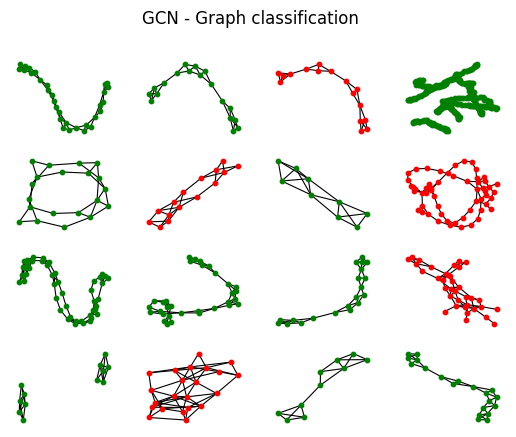

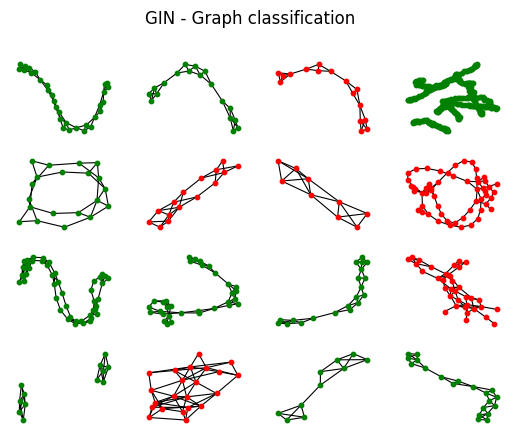

In [24]:
visualization = Visualization(dataset.dataset, gcn, gin)
visualization.plot_classification_results()

### **Evaluate ensemble performance of GCN and GIN models**

In [25]:
ensemble_evaluator = EnsembleEvaluator(gcn, gin, dataset.test_loader)
ensemble_evaluator.evaluate()

GCN accuracy:     68.75%
GIN accuracy:     73.96%
GCN+GIN accuracy: 69.27%
